<a href="https://colab.research.google.com/github/PytorchLightning/pytorch-lightning/blob/master/notebooks/06-cifar10-pytorch-lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Lightning Semantic Segmentation Tutorial ⚡


Main takeaways:
1. Experiment with different Learning Rate schedules and frequencies in the configure_optimizers method in pl.LightningModule
2. Use an existing Resnet architecture with modifications directly with Lightning

---

  - Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
  - Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/latest/)
  - Join us [on Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-f6bl2l0l-JYMK3tbAgAmGRrlNr00f1A)

### Setup
Lightning is easy to install. Simply `pip install pytorch-lightning`.
Also check out [bolts](https://github.com/PyTorchLightning/pytorch-lightning-bolts/) for pre-existing data modules and models.

In [ ]:
! pip install pytorch-lightning lightning-bolts -qU

In [ ]:
! nvidia-smi

Wed Mar 31 19:44:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Run this if you intend to use TPUs
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [ ]:
import os

import matplotlib.pylab as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pl_bolts.datamodules.kitti_datamodule import KittiDataModule

/usr/local/lib/python3.7/dist-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  f' install it with `pip install {pypi_name}`.' + extra_text


In [ ]:
pl.seed_everything(7)

Global seed set to 7


7

### KITTI Semantic Segmentation dataset

Class for KITTI Semantic Segmentation Benchmark dataset Dataset link - http://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015

There are 34 classes in the given labels. However, not all of them are useful for training (like railings on highways, road dividers, etc.).
So, these useless classes (the pixel values of these classes) are stored in the `void_labels`.
The useful classes are stored in the `valid_labels`.

The `encode_segmap` function sets all pixels with any of the `void_labels` to `ignore_index` (250 by default). It also sets all of the valid pixels to the appropriate value between 0 and `len(valid_labels)` (since that is the number of valid classes), so it can be used properly by the loss function when comparing with the output.

The `get_filenames` function retrieves the filenames of all images in the given `path` and saves the absolute path in a list.

In the `get_item` function, images and masks are resized to the given `img_size`, masks are encoded using `encode_segmap`, and given `transform` (if any) are applied to the image only (mask does not usually require transforms, but they can be implemented in a similar way).

In [ ]:
from google.colab import drive
# connect to  my gDrive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# copy the dataset to local drive
! cp /content/gdrive/Shareddrives/Datasets/data_semantics.zip .
# extract dataset to the drive
! unzip -q data_semantics.zip
! ls -l

replace testing/image_2/000000_10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
total 320040
-rw------- 1 root root 327699796 Mar 31 19:44 data_semantics.zip
drwx------ 6 root root      4096 Mar 31 19:22 gdrive
drwxr-xr-x 3 root root      4096 Mar 31 19:38 lightning_logs
drwxr-xr-x 1 root root      4096 Mar 25 13:38 sample_data
drwxrwxr-x 3 root root      4096 Apr 12  2018 testing
drwxrwxr-x 6 root root      4096 Apr 12  2018 training


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image size: torch.Size([3, 376, 1242])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


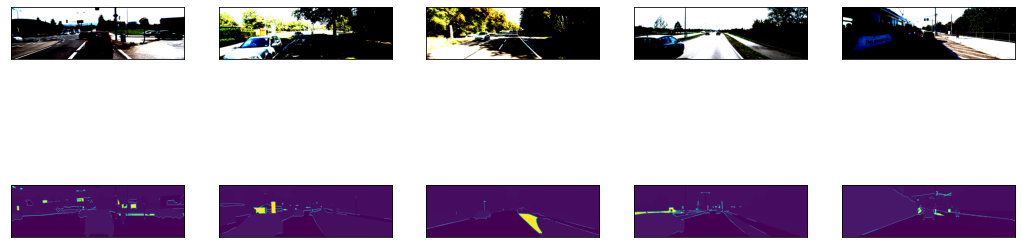

In [ ]:
dm = KittiDataModule()
dm.setup()

# quick view
nb_col = 5
fig = plt.figure(figsize=(18, 6))
for imgs, lbs in dm.train_dataloader():
  print(f'image size: {imgs[0].shape}')
  for i in range(nb_col):
    ax = fig.add_subplot(2, nb_col, i + 1, xticks=[], yticks=[])
    ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
    ax = fig.add_subplot(2, nb_col, i + 1 + nb_col, xticks=[], yticks=[])
    ax.imshow(lbs[i].numpy())
  break


### Lightning Module - Semantic Segmentation

This is a basic semantic segmentation module implemented with Lightning.
It uses CrossEntropyLoss as the default loss function. May be replaced with other loss functions as required.
It is specific to KITTI dataset i.e. dataloaders are for KITTI and Normalize transform uses the mean and standard deviation of this dataset.
It uses the FCN ResNet50 model as an example.

Adam optimizer is used along with Cosine Annealing learning rate scheduler.

In [ ]:
from pl_examples.domain_templates.unet import UNet

class SegModel(pl.LightningModule):

    def __init__(
        self,
        batch_size: int = 4,
        lr: float = 1e-3,
        num_layers: int = 3,
        features_start: int = 64,
        bilinear: bool = False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.learning_rate = lr
        self.num_layers = num_layers
        self.features_start = features_start
        self.bilinear = bilinear

        self.net = UNet(
            num_classes=19,
            num_layers=self.num_layers,
            features_start=self.features_start,
            bilinear=self.bilinear,
        )

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self(img)
        loss = F.cross_entropy(out, mask, ignore_index=250)
        log_dict = {'train_loss': loss}
        return {'loss': loss, 'log': log_dict, 'progress_bar': log_dict}

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self(img)
        loss_val = F.cross_entropy(out, mask, ignore_index=250)
        return {'val_loss': loss_val}

    def validation_epoch_end(self, outputs):
        loss_val = torch.stack([x['val_loss'] for x in outputs]).mean()
        log_dict = {'val_loss': loss_val}
        return {'log': log_dict, 'val_loss': log_dict['val_loss'], 'progress_bar': log_dict}

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

In [ ]:
model = SegModel(num_layers=1, batch_size=2, features_start=8)

trainer = pl.Trainer(
    progress_bar_refresh_rate=2,
    max_epochs=40,
    gpus=1,
    #logger=pl.loggers.TensorBoardLogger('lightning_logs/'),
    #callbacks=[LearningRateMonitor(logging_interval='step')],
)

trainer.fit(model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | UNet | 1.0 K 
------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


RuntimeError: ignored

In [ ]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

<code style="color:#792ee5;">
    <h1> <strong> Congratulations - Time to Join the Community! </strong>  </h1>
</code>

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool tools we're building.

* Please, star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning)

### Join our [Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-f6bl2l0l-JYMK3tbAgAmGRrlNr00f1A)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself and share your interests in `#general` channel

### Interested by SOTA AI models ! Check out [Bolt](https://github.com/PyTorchLightning/pytorch-lightning-bolts)
Bolts has a collection of state-of-the-art models, all implemented in [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) and can be easily integrated within your own projects.

* Please, star [Bolt](https://github.com/PyTorchLightning/pytorch-lightning-bolts)

### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/pytorch-lightning-bolts) GitHub Issues page and filter for "good first issue". 

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/pytorch-lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

<img src="https://github.com/PyTorchLightning/pytorch-lightning/blob/master/docs/source/_static/images/logo.png?raw=true" width="800" height="200" />